In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing, decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model.stochastic_gradient import SGDClassifier
import time

In [2]:

artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

In [3]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

In [4]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

In [5]:
artworks.Nationality.unique()

array(['(Austrian)', '(French)', '()', '(American)', '(German)',
       '\\(multiple_nationalities\\)', '(Swedish)', '(British)',
       '(Japanese)', '(Italian)', '(Argentine)', '(Swiss)', '(Brazilian)',
       '(Luxembourgish)', '(Spanish)', '(Dutch)', '(Russian)', '(Iranian)',
       '(Finnish)', '(Nationality unknown)', '(Danish)', '(Moroccan)',
       '(Colombian)', '(Australian)', '(Hungarian)', '(Belgian)',
       '(Canadian)', '(Slovenian)', '(Chilean)', '(Mexican)', '(Yugoslav)',
       '(Latvian)', '(Nationality Unknown)', '(Polish)', '(Czech)',
       '(Israeli)', '(Czechoslovakian)', '(Croatian)', '(Norwegian)',
       '(Cuban)', '(Romanian)', '(Venezuelan)', '(Uruguayan)', '(Greek)',
       '(Ukrainian)', '(Various)', '(Thai)', '(Algerian)', '(Icelandic)',
       '(Guatemalan)', '(Indian)', '(Chinese)', '(Irish)', '(Costa Rican)',
       '(Korean)', '(Ethiopian)', '(Kuwaiti)', '(Haitian)', '(Scottish)',
       '(South African)', '(Zimbabwean)', '(Portuguese)', '(Panamanian

In [6]:
artworks1 = artworks.loc[~(artworks['Nationality'] == '()')]
artworks1 = artworks1.loc[~(artworks['Nationality'] == '(nationality unknown)')]
artworks1 = artworks1.loc[~(artworks['Nationality'] == '(Nationality unknown)')]
artworks1 = artworks1.loc[~(artworks['Nationality'] == '(Nationality Unknown)')]
artworks1['Nationality'].replace('\\(multiple_nationalities\\)', '(Multiple Nationalities)', inplace=True)

In [7]:
artworks1['Nationality'] = artworks1['Nationality'].apply(str).str.replace('\(|\)','')

In [8]:
artworks1.Nationality.unique()

array(['Austrian', 'French', 'American', 'German',
       'Multiple Nationalities', 'Swedish', 'British', 'Japanese',
       'Italian', 'Argentine', 'Swiss', 'Brazilian', 'Luxembourgish',
       'Spanish', 'Dutch', 'Russian', 'Iranian', 'Finnish', 'Danish',
       'Moroccan', 'Colombian', 'Australian', 'Hungarian', 'Belgian',
       'Canadian', 'Slovenian', 'Chilean', 'Mexican', 'Yugoslav',
       'Latvian', 'Polish', 'Czech', 'Israeli', 'Czechoslovakian',
       'Croatian', 'Norwegian', 'Cuban', 'Romanian', 'Venezuelan',
       'Uruguayan', 'Greek', 'Ukrainian', 'Various', 'Thai', 'Algerian',
       'Icelandic', 'Guatemalan', 'Indian', 'Chinese', 'Irish',
       'Costa Rican', 'Korean', 'Ethiopian', 'Kuwaiti', 'Haitian',
       'Scottish', 'South African', 'Zimbabwean', 'Portuguese',
       'Panamanian', 'Ecuadorian', 'Peruvian', 'Congolese', 'Malian',
       'Turkish', 'Cambodian', 'Bosnian', 'Canadian Inuit', 'Estonian',
       'Pakistani', 'Bolivian', 'Palestinian', 'Taiwanese', 'P

In [9]:
artworks1 = artworks1.loc[~(artworks['Gender'] == '()')]
artworks1['Gender'].replace('(male)', '(Male)', inplace=True)
artworks1['Gender'].replace('\\(multiple_persons\\)', '(Various Painters)', inplace=True)
artworks1['Gender'] = artworks1['Gender'].apply(str).str.replace('\(|\)','')

In [10]:
artworks1.Gender.unique()

array(['Male', 'Various Painters', 'Female'], dtype=object)

In [11]:
artworks1['DateAcquired'] = pd.to_datetime(artworks1.DateAcquired)
artworks1['YearAcquired'] = artworks1.DateAcquired.dt.year
artworks1['YearAcquired'].dtype

dtype('int64')

In [12]:
# Convert dates to start date, cutting down number of distinct examples.
artworks1['Date'] = pd.Series(artworks1.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks1.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date','URL','ThumbnailURL'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks1.Artist)
nationalities = pd.get_dummies(artworks1.Nationality)
dates = pd.get_dummies(artworks1.Date)

# Concat artists with other variables
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)

Y = artworks1.Department

In [13]:
#Preproces the ratings
names = X.columns
X_scaled = pd.DataFrame(preprocessing.scale(X), columns = names)

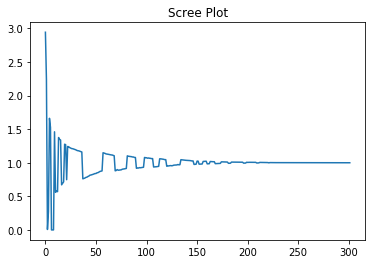

The percentage of total variance in the dataset explained 
 [  2.74348672e-02   1.59435728e-02   8.67333554e-03   7.29524552e-03
   6.75307988e-03   5.93666094e-03   5.75004211e-03   5.67832197e-03
   5.15704085e-03   5.10494183e-03   4.88694404e-03   4.85110340e-03
   4.74580264e-03   4.70259967e-03   4.64384639e-03   4.63105722e-03
   4.57766040e-03   4.54931534e-03   4.51130290e-03   4.44637737e-03
   4.40765648e-03   4.39221686e-03   4.35394910e-03   4.31319028e-03
   4.26001266e-03   4.18381250e-03   4.14151677e-03   4.10765713e-03
   4.05692038e-03   4.04096937e-03   4.01942669e-03   3.99430709e-03
   3.96415459e-03   3.95313178e-03   3.94242879e-03   3.90426612e-03
   3.86327515e-03   3.85626348e-03   3.81517043e-03   3.79666988e-03
   3.78320053e-03   3.77319702e-03   3.73991596e-03   3.73443227e-03
   3.69145078e-03   3.68463305e-03   3.68310578e-03   3.66334588e-03
   3.65481488e-03   3.63525928e-03   3.61256980e-03   3.60921395e-03
   3.59466801e-03   3.57566861e-03   3.5708

In [14]:
#PCA Analysis
# Build the correlation mtarix
correlation_matrix = X_scaled.corr()

#Calculate the eigenvectores & eigenvalues
eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)
sklearn_pca = PCA(n_components=len(X_scaled.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

#Plot the scree plot for visual analysis of the PCA features
plt.title('Scree Plot')
plt.plot(eig_vals)
plt.show()

#For additional aid, print the total variance explained by each of the eigenvalues
print('The percentage of total variance in the dataset explained \n', sklearn_pca.explained_variance_ratio_)

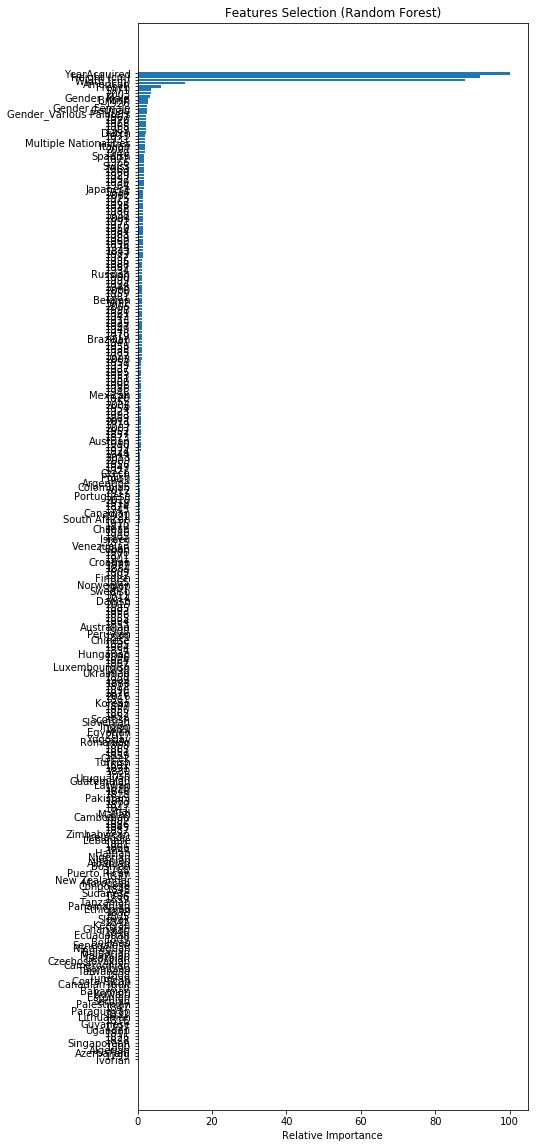

In [15]:
#Calculate Feature Importance using Random Forest
#Start and fit the Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_scaled, Y)

#Define feature importance
feature_importance = rf.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot the relative importance of each feature
plt.figure(figsize=(7, 20))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Features Selection (Random Forest)')
plt.show()

In [16]:
#Feature Selection using KBest
#Scores for the most relevant features start with the one that has more explanatory power
# Initialize and fit the model for features extraction
test = SelectKBest()
fit = test.fit(X_scaled, Y)

#Identify features with highest score from a predictive perspective
#Create dataframe with the features ordered by their explanatory power
features_names = X_scaled.columns
Bestfeatures = pd.DataFrame(fit.scores_, index = features_names)
Bestfeatures.columns = ['Best Features']
Bestfeatures.sort_values(by=['Best Features'], ascending=False).head(30)

,Best Features
Height (cm),4044.423777
Width (cm),2383.681027
French,1597.309307
American,1346.024309
Gender_Various Painters,1069.316013
Multiple Nationalities,1069.316013
YearAcquired,1038.534357
2003,844.596609
Swiss,389.781312
Spanish,311.846061


In [17]:
# Features selection with Recursive Feature Elimination RFE model
#Set up the max number of features as indicated by PCA Analysis: number of features = 6
n_features = len(X_scaled)

#Initialize the model and fit
lr = LogisticRegression()
rfe = RFE(lr,n_features)
fit = rfe.fit(X_scaled,Y)

# Summarize the features selection. Based on the number of features from the PCA analysis
#show all the features selected (true) and left out (false)
result_RFE = pd.DataFrame(list(zip(X_scaled.head(0), rfe.ranking_, rfe.support_)),columns=['Features','Ranking','Support'] )
result_RFE.sort_values('Ranking').head(30)

,Features,Ranking,Support
0,Height (cm),1,True
204,1920,1,True
203,1919,1,True
202,1918,1,True
201,1917,1,True
200,1916,1,True
199,1915,1,True
205,1921,1,True
198,1914,1,True
196,1912,1,True


In [21]:
X_selected = X_scaled[['Height (cm)', 'Width (cm)', 'French','American',
              'Gender_Various Painters','Multiple Nationalities',
              'YearAcquired','2003', 'Swiss', 'Spanish', '1971', '1926', 'Portuguese',
              '1860', 'Dutch', 'Gender_Female', '1940', '1869', '2002',
              '1857', '2004', '1843', '1873', '1914', 'Belgian', '1899', '1875']]

In [22]:
#Split the data into training and testing datasets. Split: 70/30; train/test

X_train, X_test, y_train, y_test = train_test_split(X_selected,Y, test_size=0.3, random_state=123)

#Initiating the cross validation generator, N splits = 5

kf = KFold(5)

In [36]:
# Initialize and fit the model.
mlp = MLPClassifier(max_iter=500, tol = 0.001)

#Tune hyperparameters
#Create range of values to fit parameters

hidden_layer_sizes= [(100,20,), (200,50,), (400,100,)]
activation = ['logistic']
learning_rate_init = [0.001, 0.01, 1]

parameters = {'hidden_layer_sizes': hidden_layer_sizes,
             'activation': activation,
             'learning_rate_init': learning_rate_init}

#Fit parameters using gridsearch
mlp_tuned = GridSearchCV(mlp, param_grid=parameters, cv=3)

#Fit the tunned classifier in the training space
mlp_tuned.fit(X_train, y_train)

#Print the best parameters
print(mlp_tuned.best_params_)    

#Print mlp score
print(mlp_tuned.score(X_train, y_train))

{'activation': 'logistic', 'hidden_layer_sizes': (400, 100), 'learning_rate_init': 0.001}
0.740305709663


In [37]:
#Fit on Test set
mlp_tuned.fit(X_test, y_test)

predtest_y = mlp_tuned.predict(X_test)

In [38]:
cross_val_score(mlp_tuned, X_test, y_test, cv=3).mean()

0.67466662578177861

In [39]:
Y.value_counts()/len(Y)

Prints & Illustrated Books    0.536797
Photography                   0.214247
Drawings                      0.108565
Architecture & Design         0.104156
Painting & Sculpture          0.036235
Name: Department, dtype: float64

In the artwork dataset, a multi-layer perceptron has been run on the selected features. The features have been selected using Random Forest, KBest and RFE.

The final features that have been used are:

'Height (cm)', 'Width (cm)', 'French','American','Gender_Various Painters','Multiple Nationalities','YearAcquired','2003', 'Swiss', 'Spanish', '1971', '1926', 'Portuguese', '1860', 'Dutch', 'Gender_Female', '1940', '1869', '2002', '1857', '2004', '1843', '1873', '1914', 'Belgian', '1899', '1875'

The overall accuracy has been increased form an initial 55% to 67% (cross validation accuracy) by increasing the number of hidden layers to 2 with 400 and 100 neurons. Furthermore, the learning rate_init has been set to 0.001 from 1e-4 and the activation functions is logistic. All the parameters have been set using GridsearchCV with 3 folds.